# This notebook explores the uncertainty from folding a known exponential spectra through the MagEIS geometric factors with uncertainty

In [1]:
import numpy as np
import pymc3 as pm
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.integrate
import scipy.interpolate
sns.set(font_scale=1.5)
%matplotlib inline
import sys
import h5py

sys.path.append('../utils/')
import mageis_response

WARNING (theano.tensor.blas): Using NumPy C-API based implementation for BLAS functions.
/packages2/.packages2/x86_64-pc-linux-gnu-rhel7/python/3.6.0/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


Create a true exponential spectra with E0t and J0t parameters. Then use that spectra and fold it through the MagEIS response functions to get the true counts.

In [2]:
# Spectra parameters
E0t = 100 # keV
J0t = 1E4 # 1/(cm^2 sr s keV)

# Initialize the response function
R = mageis_response.R_iso(101) # RBSP-A MagEIS LOW.
E = R.E*1000 # Energy array in keV.
FEDU_energy = [ 15.,  20.,  33.,  54.,  80., 108., 143., 184., 226.] # keV
n_ch = (1, 9) # Channels to use (1 through 9 are the main rate channels.)

# Interpolate the response functions so we can easily add uncertainty to them
# G is a function of energy that returns G(E) for all energy channels.
G = scipy.interpolate.interp1d(E, [R.response(i) for i in range(*n_ch)], axis=1)

# Define an exponential spectra.
def spectra(Earr, J0, E0):
    return(J0*np.exp(-Earr/E0))

# Now create the "true" counts drawn from the parent distribution. This assumes there
# is no uncertanity.
true_lambda = np.nan*np.zeros(n_ch[1]-n_ch[0])
for i in range(*n_ch):
    true_lambda[i-n_ch[0]] = scipy.integrate.trapz(spectra(E, J0t, E0t)*R.response(i), x=E)

Since pymc3 does not natively do integrationm, now we code in a trapezium integrator (validated). Also define a pumc3 exponential spectra.

In [3]:
def pymcTrapz(f, x):
    """
    This function is the pymc3 Trapz implementation for an uneven grid.
    It integrates a function f over an uneven grid x.
    """
    return 0.5*pm.math.dot((f[1:] + f[:-1]), (x[1:] - x[:-1]))

def pymcExpSpectra(E, E0, J0):
    return J0*pm.math.exp(-E/E0)

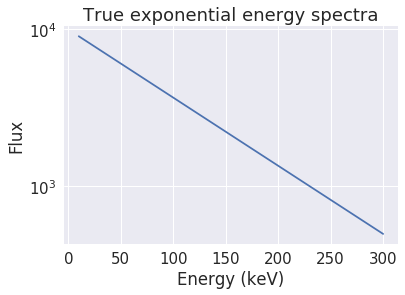

In [4]:
plt.plot(E, spectra(E, J0t, E0t)); plt.title('True exponential energy spectra')
plt.yscale('log'); plt.xlabel('Energy (keV)'); plt.ylabel('Flux');

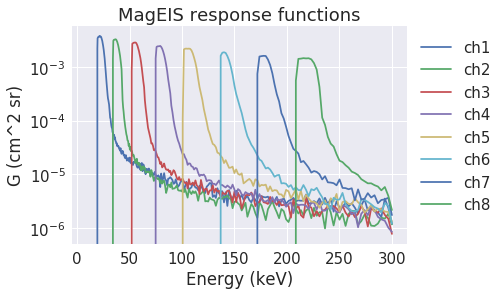

In [5]:
for i in range(*n_ch):
    plt.plot(E, R.response(i), label='ch{}'.format(i));
plt.xlabel('Energy (keV)'); plt.ylabel('G (cm^2 sr)'); 
plt.title('MagEIS response functions'); plt.yscale('log');
plt.legend(bbox_to_anchor=(1, 1)); #plt.savefig('response.png', dpi=300)

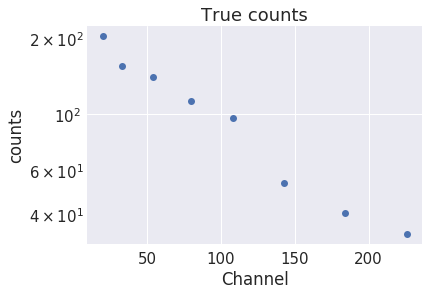

In [6]:
plt.semilogy(FEDU_energy[n_ch[0]:n_ch[1]], true_lambda, 'o'); 
plt.ylabel('counts'); plt.xlabel('Channel'); plt.title('True counts');

Now add realism by drawing observed counts from true_lambda assuming a Poisson process

In [7]:
np.random.seed(123)
c_obs = np.random.poisson(true_lambda)

Visualize the counts derived from the spectra without uncertainty, and the counts that could have been observed if we assume a poisson process

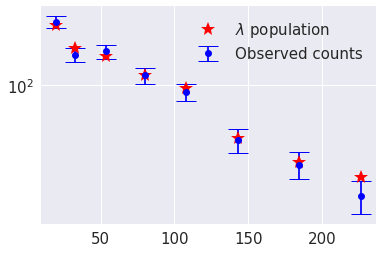

In [8]:
(_, caps, _) = plt.errorbar(FEDU_energy[n_ch[0]:n_ch[1]], c_obs, yerr=np.sqrt(c_obs), c='b', fmt='o', 
                            label='Observed counts', capsize=10)
for cap in caps:
    cap.set_markeredgewidth(1)
plt.plot(FEDU_energy[n_ch[0]:n_ch[1]], true_lambda, 'r*', ms=15, 
         label=r'$\lambda$ population')
plt.yscale('log'); plt.legend();

### Bayes model
Here we explore how to back out the exponential spectra from the observed counts. We work with informed and uninformed spectral parameter priors (switch below) and add uncertnaity to the response functions (scale up/down, move left/right).

The number of divergences increases as the FWHM offset increases.

In [9]:
traces = {}
informedPrior = True # use uniform or normal priors on J0 and E0.

# This sets the R(E) scale to unity or normally distributed.
# If False (or 0), will not modify the response functions.
Roffset = [10, 50, 100] # R(E) fwhm amplitude offset off if 0 (percent) 
Eoffset = [0, 0, 0] # R(E) fwhm energy offset off if 0 (percent)

def getPriors(informedSpecP, Roffset, Eoffset):
    """
    This function handles the exponential spectra priors, 
    and can add uncertnaity to the G(E) emplitude and
    energy offset.
    """
    if informedSpecP:
        BoundedNormal = pm.Bound(pm.Normal, lower=0.0)
        J0 = BoundedNormal('J0', mu=1E4, sd=1E5)
        E0 = BoundedNormal('E0', mu=100, sd=500)
    else:
        J0 = pm.Uniform('J0', lower=0, upper=1E7)
        E0 = pm.Uniform('E0', lower=0, upper=500)
    
    # G(E) modifications
    if Roffset:
        Roff = pm.Normal('Roff', mu=1, 
                         sd=Roffset/(100*2*np.sqrt(2*np.log(2))), 
                         shape=len(c_obs))
    else:
        Roff = np.ones_like(c_obs)
    if Eoffset:
        Eoff = pm.Normal('Eoff', mu=1, 
                         sd=Eoffset/(100*2*np.sqrt(2*np.log(2))), 
                         shape=len(c_obs))
    else:
        Eoff = np.ones_like(c_obs)
    return E0, J0, Roff, Eoff

def lam(E0, J0, Roffset, Eoffset):
    """
    This function appears to the only way to correctly work with pymc3 and 
    propagate the sampled spectra though the instrument response functions.
    My implementation of trapezium is not the fastest, but it will do.
    """
    lams = len(c_obs)*[None]
    
    for i in range(len(c_obs)):
        J = pymcExpSpectra(E*Eoffset[i], E0, J0)
        #f is chanel-dependent offset * flux arr * interpolated 
        # G(E * a random energy offset)
        f = Roffset[i]*J*G(E)[i]  #G(E*Eoffset[i])[i] 
        lams[i] = pm.Deterministic('lam{}'.format(i), pymcTrapz(f, E))
    return lams

for Rerr, Eerr in zip(Roffset, Eoffset):
    m = pm.Model()
    print('Running with Rerr = {} % and Eerr = {} %'.format(Rerr, Eerr))
    with m:
        # Prior stocastic variables
        prior = getPriors(informedPrior, Rerr, Eerr)
        lams = lam(*prior) # Get prior determanistic variables

        c_m = pm.Poisson('c_m', mu=lams, observed=c_obs, shape=len(c_obs)) # Likeleyhood
        trace = pm.sample(1E4, tuning=1000, cores=3) # MCMC
    traces['RERR{:02d}_EERR{:02d}'.format(Rerr, Eerr)] = trace

Running with Rerr = 10 % and Eerr = 0 %


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (3 chains in 3 jobs)
NUTS: [Roff, E0_lowerbound__, J0_lowerbound__]
  3%|▎         | 301/10500.0 [00:06<03:29, 48.72it/s]INFO (theano.gof.compilelock): Waiting for existing lock by process '15733' (I am process '15734')
INFO (theano.gof.compilelock): To manually release the lock, delete /home/msshumko/.theano/compiledir_Linux-3.10-el7.x86_64-x86_64-with-redhat-7.5-Maipo-x86_64-3.6.0-64/lock_dir
100%|██████████| 10500/10500.0 [00:39<00:00, 265.63it/s]


Running with Rerr = 50 % and Eerr = 0 %


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (3 chains in 3 jobs)
NUTS: [Roff, E0_lowerbound__, J0_lowerbound__]
100%|██████████| 10500/10500.0 [01:29<00:00, 117.16it/s]
The acceptance probability does not match the target. It is 0.8995439175628107, but should be close to 0.8. Try to increase the number of tuning steps.


Running with Rerr = 100 % and Eerr = 0 %


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (3 chains in 3 jobs)
NUTS: [Roff, E0_lowerbound__, J0_lowerbound__]
100%|██████████| 10500/10500.0 [02:18<00:00, 75.69it/s]
There were 4 divergences after tuning. Increase `target_accept` or reparameterize.
The number of effective samples is smaller than 25% for some parameters.


In [10]:
# Save data
if False:
    with h5py.File('rerr_traces.h5', 'a') as hf:
        for tKey in traces.keys():
            g = hf.create_group(tKey)
            #sDict = {'E0':traces[tKey][:]['E0'], 'J0':traces[tKey][:]['J0']}
            #print(sDict)
            #hf.create_group(tKey, data=sDict)
            g.create_dataset('E0', data=traces[tKey][:]['E0'])
            g.create_dataset('J0', data=traces[tKey][:]['J0'])
        try:
            g2 = hf.create_group('GLOBAL')
            g2.create_dataset('TRUE_E0', data=E0t)
            g2.create_dataset('TRUE_J0', data=J0t)
        except ValueError as err:
            if 'Unable to create group' in str(err):
                pass
            else:
                raise

In [11]:
#pm.traceplot(trace, combined=True);

In [12]:
#pm.summary(trace)

In [13]:
#c_mean = [np.mean(trace['lam{}'.format(i)]) for i in range(len(c_obs))]
#c_std = [np.std(trace['lam{}'.format(i)]) for i in range(len(c_obs))]
#c_ci = np.asarray([np.percentile(trace['lam{}'.format(i)], (2.5, 97.5)) 
#                    for i in range(len(c_obs))])

In [14]:
#plt.hist(trace['J0'], bins=100, label='trace')
#plt.axvline(J0t, c='r', lw=4, label='True value');
#plt.legend();

In [15]:
#plt.hist(trace['E0'], bins=100, label='trace');
#plt.axvline(E0t, c='r', lw=4, label='True value');
#plt.legend();

In [16]:
E0_mu = [np.mean(traces[key][:]['E0']) for key in traces.keys()]
E0_ci = [np.percentile(traces[key][:]['E0'], (2.5, 97.5)) for key in traces.keys()]

KeyboardInterrupt: 

In [ ]:
E0_mu, E0_ci

In [ ]:
for i, key in enumerate(traces.keys()):
    plt.hist(traces[key][:]['E0'], bins=100, alpha=0.5, label=key)
    plt.axvline(E0_mu[i])
plt.xlim(50, 300); plt.legend(bbox_to_anchor=(1, 1));

## Statistics of the J0 and E0 distributions that are consistant with the observed counts 
Now we calculate the statistics of 100 spectra drawn from the trace (mean, median, 2.5%, and 95% credible interval) as a function of energy

Pick 100 random draws of E0 and J0 from the trace, and calculate the statistics on those draws as a function of energy.

In [ ]:
nS = 100
random_samples = np.random.randint(0, len(trace), nS)
dist = np.zeros((len(E), nS), dtype=float)
for (i, s) in enumerate(random_samples):
    for e in range(len(E)):
        dist[e, i] = spectra(E, trace['J0'][s], trace['E0'][s])[e]

In [ ]:
plt.plot(E, spectra(E, J0t, E0t), 'b--', label='True model')
for i in random_samples:
    plt.plot(E, spectra(E, trace['J0'][i], trace['E0'][i]), c='k', alpha=0.07)
plt.plot(E, np.mean(dist, axis=1), label='mean');
plt.plot(E, np.percentile(dist, 2.5, axis=1), '--', label='2.5 percentile')
plt.plot(E, np.percentile(dist, 97.5, axis=1), '--', label='97.5 percentile', c='c')
plt.legend(); plt.yscale('log'); plt.ylabel('Flux [unitless]');
plt.xlabel('Energy [keV]'); plt.title('95% credible interval | exponential spectra');

Calculate the credible intervals for E0 and J0

In [ ]:
J0_ci = np.percentile(trace['J0'], (2.5, 97.5)); 
E0_ci = np.percentile(trace['E0'], (2.5, 97.5));

print('J0_ci = {}, E0_ci = {}'.format(J0_ci, E0_ci))